'''
MD simulation of Lennard-Jones fluids
modified from
https://github.com/basnijholt/molecular-dynamics-Python/blob/master/MD.ipynb
The original code is wrong. If you simply copy it, you will get ZERO mark!
Reduced unit: \sigma=\epsilon=mass=k_B=1
'''

'''
Import required packages
'''

In [1]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
rho =0.8676 # density of Argon in reduced units
T_0 = 1.6945 # temperature in reduced units
N_cell = 3 # number of fcc unitcells in one direction    
N = 4 * N_cell ** 3 # the total number of particles in the system
L_box = (N / rho) ** (1 / 3.0) # length of the whole simulation box
L_cell = L_box / N_cell # length of a unitcell
F = np.zeros((N, N, 3)) # matrix that contains all forces
ind = np.triu_indices(N, k=1) # indices of upper triangular matrix
l_0 = 0.3405 #length unit
t_0 = 2.1562 #time unit
v_0 = l_0 / t_0 #velocity unit
dt = 0.004 #time step
bins = 30

In [3]:
def IC_pos(N_cell, L_cell):
    '''
    use fcc structure to initilize positions
    '''
    pos = [[[x,  y, z], [x, 0.5 + y, 0.5 + z], [0.5 + x, y, 0.5 + z], [0.5 + x, 0.5 + y, z]] 
           for x, y, z in product(range(N_cell), range(N_cell), range(N_cell))]
    pos = np.array(pos).reshape((-1, 3))
    return pos * L_cell

In [4]:
def IC_vel(N):
    '''
    Maxwell-Boltzman distribution is a normal distribution
    '''
    vel = np.sqrt(T_0) * np.random.randn(N, 3)
    vel -= np.average(vel, axis=0)
    return vel 

In [5]:
def find_force(pos, L_box=L_box):
    '''
    Minimum image convention. 
    '''
    r_vec = pos[ind[0]] - pos[ind[1]]
    r_vec = r_vec - np.rint(r_vec / L_box) * L_box
    r_sq = np.sum(r_vec**2, axis=1)
    F_vec = -(48 / r_sq ** 7 - 24 / r_sq ** 4)[:, None] * r_vec
    F[ind[0], ind[1]] = F_vec
    pot = np.sum(4 / r_sq ** 6 - 4 / r_sq ** 3)
    #P = np.sum(F_vec * r_vec)
    hist = np.histogram(np.sqrt(r_sq), bins = bins, range = (0, L_box / 2))[0]
    return np.sum(F, axis=0) - np.sum(F, axis=1), pot, hist

In [6]:
def time_step(pos, vel, F):
    vel += 0.5 * F * dt
    pos = pos + vel * dt
    pos_folded = np.mod(pos, L_box)
    #pos = np.mod(pos + vel * dt, L_box) # why both pos and pos_folded? 
    F, pot, hist= find_force(pos_folded)
    
    vel += 0.5 * F * dt
    kin = 0.5 * np.sum(vel**2)
    return pos_folded, pos, vel, F, pot, kin, hist

In [7]:
def simulate():
    output = open('argon.gro','w')
    kins, pots, hists = [], [], []
    ps, vs = [], []
    pos = IC_pos(N_cell, L_cell)
    vel = IC_vel(N)
    F = find_force(pos)[0]
    for t in range(2000):
        pos_folded, pos, vel, F, pot, kin, hist = time_step(pos, vel, F)
        if t > 1000:  # production run
            kins.append(kin)
            pots.append(pot)
            hists.append(hist)
            output.write("t=%10.5f\n"%(t*dt*t_0))
            output.write("%5d\n"%N)
            for i in range(N):
                output.write("%7s%5s%5d%8.3f%8.3f%8.3f%8.4f%8.4f%8.4f\n" \
                %("ATOM","Ar",i+1,pos_folded[i][0]*l_0,pos_folded[i][1]*l_0,pos_folded[i][2]*l_0, \
                vel[i][0]*v_0,vel[i][1]*v_0,vel[i][2]*v_0))
            output.write("%10.5f%10.5f%10.5f\n"%(L_box*l_0,L_box*l_0,L_box*l_0))
            ps.append(pos*l_0)
            vs.append(vel*v_0)
        else: # equillirum run
            vel *= np.sqrt(N * 3 * T_0 / (2 * kin))
    return np.array(kins), np.array(pots), np.mean(hists, axis = 0), np.array(ps), np.array(vs)

'''
Energy as a function time
'''

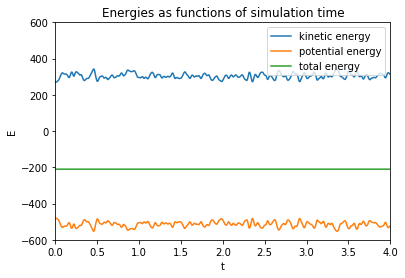

In [8]:
kins, pots, hist, ps, vs = simulate()
time = [dt * i for i in range(len(kins))]
plt.plot(time, kins, label = 'kinetic energy')
plt.plot(time, pots, label = 'potential energy')
plt.plot(time, kins + pots, label = 'total energy')
plt.legend(loc = 'upper right')
plt.ylim(-600,600)
plt.xlim(0,4.0)
plt.xlabel('t')
plt.ylabel('E')
plt.title('Energies as functions of simulation time')

'''
Radial distribution function
'''

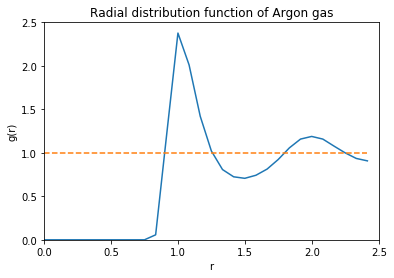

In [9]:
dr = L_box/2/bins
rs, gs = [], []
for i in range(bins):
    r = i*dr
    g = 2*hist[i]*3/(4*np.pi*((r+dr)**3-r**3)*rho*N)
    rs.append(r)
    gs.append(g)

plt.plot(rs, gs)
plt.plot(rs, [1 for i in range(bins)], '--')
plt.ylim(0, 2.5)
plt.xlim(0, 2.5)
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Radial distribution function of Argon gas')

'''Einstein relation'''

D in Einstein relation is : 0.0046 nm^2/ps


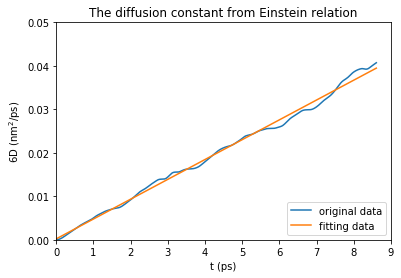

In [22]:
num = 999 #number of frames from production run
t = [dt * i * t_0 for i in range(len(kins))]
ms = []
f1 = open('msd.txt','w')
for i in range(num):
    msd = 0
    for j in range(N):
        msd += np.sum((ps[i][j]-ps[0][j])**2)
    msd = msd / (6*N)
    ms.append(msd)
#Do the linear fitting and print out the diffusion constant.
z = np.polyfit(t, ms , 1)
p = np.poly1d(z)
print("D in Einstein relation is : %.4f nm^2/ps"%(z[0]))
plt.plot(t, ms, label = 'original data')
plt.plot(t, p(t), '-',label = 'fitting data')
plt.legend(loc = 'lower right')
plt.xlim(0,9)
plt.ylim(0,0.05)
plt.xlabel('t (ps)')
plt.ylabel('6D (nm$^2$/ps)')
plt.title('The diffusion constant from Einstein relation')

'''Green-Kubo relation'''

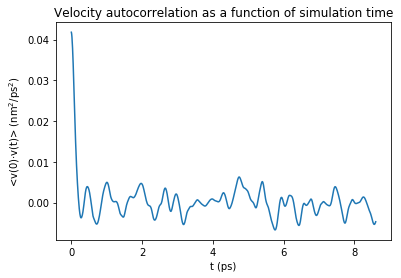

In [16]:
sum_vac = 0
vacs, sum_vacs = [], []
for i in range(num):
    vac = 0
    for j in range(N):
        vac += np.dot(vs[i][j],vs[0][j])
    vac = vac / (3*N)
    sum_vac += vac * dt * t_0
    vacs.append(vac)
    sum_vacs.append(sum_vac)
plt.plot(t,vacs)
plt.xlabel('t (ps)')
plt.ylabel(r'<v(0)$\cdot $v(t)> (nm$^2$/ps$^2$)')
plt.title('Velocity autocorrelation as a function of simulation time')

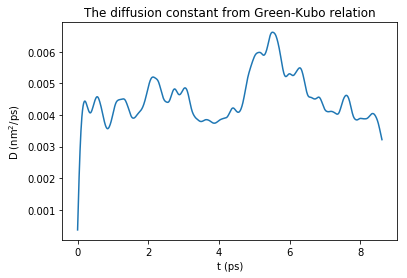

In [18]:
plt.plot(t,sum_vacs)
plt.xlabel('t (ps)')
plt.ylabel('D (nm$^2$/ps)')
plt.title('The diffusion constant from Green-Kubo relation')